#🧑‍💻 Entrenamiento del Modelo de Predicción de Precios de Viviendas

En este notebook, procederemos con el entrenamiento de un modelo de Machine Learning para predecir el precio de viviendas basándonos en diversas características, como área, número de habitaciones, tipo de mobiliario, etc. Utilizaremos el conjunto de datos previamente preprocesado y exportado en las fases anteriores. El modelo de regresión seleccionado para este propósito será `RandomForestRegressor`, un modelo robusto y adecuado para este tipo de tareas.

In [37]:
!pip install -q keras-tuner


## 🧑‍💻 Fase 1: Importar Librerías y Cargar Datos
En esta fase, importaremos las librerías necesarias y cargaremos los archivos CSV exportados previamente (conjuntos de datos de entrenamiento y prueba). Esto nos permitirá preparar los datos para el entrenamiento del modelo.

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cargar los datos de entrenamiento y prueba
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")


# Verificamos los primeros registros para asegurarnos que se cargaron correctamente
print(y_train.head())
print(X_train.head())


          0
0  1.115338
1 -0.107220
2 -0.251928
3  0.333692
4 -0.122226
       area  bedrooms  bathrooms  stories  mainroad  guestroom  basement  \
0  1.593220      -1.0        0.0     -1.0       0.0        0.0       0.0   
1 -0.154814       1.0        0.0     -1.0      -1.0        0.0       1.0   
2 -0.502184      -1.0        1.0     -1.0      -1.0        0.0       1.0   
3 -0.388258      -1.0        0.0     -1.0      -1.0        1.0       1.0   
4 -0.182072       1.0        0.0     -1.0      -1.0        0.0       1.0   

   hotwaterheating  airconditioning  parking  prefarea  \
0              0.0              1.0      1.0       0.0   
1              0.0              0.0      0.0       0.0   
2              0.0              0.0      0.0       0.0   
3              0.0              0.0      0.0       0.0   
4              0.0              0.0      0.0       0.0   

   furnishingstatus_furnished  furnishingstatus_semi-furnished  \
0                         0.0                           

## 🧑‍💻 Fase 2: Definición del Modelo y Arquitectura de la Red Neuronal

En esta fase, diseñaremos una red neuronal de regresión con las siguientes características:

- **Entrada**: 14 neuronas, una por cada característica preprocesada.
- **Capas Ocultas**: Dos capas densas con activación ReLU.
- **Salida**: 1 neurona con activación lineal para predecir el precio.

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# Definir la arquitectura de la red neuronal
model = Sequential()

# Capa de entrada (21 neuronas, una por cada característica)
model.add(Dense(21, input_dim=X_train.shape[1], activation='relu'))

# Capas ocultas (4 capas densas con activación ReLU)
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# Capa de salida (1 neurona, activación lineal)
model.add(Dense(1, activation='linear'))

# Resumen de la arquitectura del modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 21)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,661 (57.27 KB)

 Trainable params: 14,661 (57.27 KB)

 Non-trainable params: 0 (0.00 B)

##🧑‍💻 Fase 3: Compilación del Modelo
En esta fase, compilamos el modelo usando la función de pérdida **Error Cuadrático Medio (MSE)** y comparamos dos optimizadores: **Adam** y **SGD con momentum.**

In [40]:
# Compilamos el modelo con el optimizador Adam y la función de pérdida MSE
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Alternativamente, podemos usar el optimizador SGD con momentum
#model.compile(optimizer=SGD(momentum=0.9), loss='mean_squared_error')

# Early stop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
    )

# Definir el callback ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Se entrena el modelo
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[checkpoint, early_stop]
    )


Epoch 1/300
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3406
Epoch 1: loss improved from inf to 0.26892, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.3385 - val_loss: 0.1830
Epoch 2/300
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1870
Epoch 2: loss improved from 0.26892 to 0.17116, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1865 - val_loss: 0.1546
Epoch 3/300
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1593
Epoch 3: loss improved from 0.17116 to 0.14885, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1590 - val_loss: 0.1236
Epoch 4/300
 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1292
Epoch 4: loss improved from 0.14885 to 0.11658, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1280 - val_loss: 0.1727
Epoch 5/300
 90/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1044
Epoch 5: loss improved from 0.11658 to 

##🧑‍💻 Fase 4: Evaluación del Modelo
Una vez entrenado el modelo, evaluaremos su desempeño utilizando métricas de evaluación como **MAE**, **RMSE**, y **R²**. Además, implementaremos **validación cruzada K-Fold (k=5)** para verificar la estabilidad del modelo.

In [58]:
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf  # Asegúrate de tener importado tensorflow

# Cargar el modelo
model = tf.keras.models.load_model('best_model.keras')

# Evaluación del modelo en el conjunto de prueba
y_pred = model.predict(X_test)

scaler_y = joblib.load('robust_scaler_y.joblib')
scaler_x = joblib.load('robust_scaler_X.joblib')

# Desnormalizar los valores predichos y reales
y_test_desnormalized = scaler_y.inverse_transform(y_test)
y_pred_desnormalized = scaler_y.inverse_transform(y_pred)

# Métricas de evaluación
mae = mean_absolute_error(y_test_desnormalized, y_pred_desnormalized)
rmse = np.sqrt(mean_squared_error(y_test_desnormalized, y_pred_desnormalized))
r2 = r2_score(y_test_desnormalized, y_pred_desnormalized)
avg_price = np.mean(y_test_desnormalized)

# Calculo final
rmsr_percentage = (rmse / avg_price) * 100
mae = (mae / avg_price) * 100

# Imprimir resultados
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmsr_percentage:.2f}%")
print(f"R²: {r2 * 100:.2f}%")



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 3.36
RMSE: 6.16%
R²: 97.41%


#### Métricas Aceptables para el Modelo:

- **MAE (Error Absoluto Medio):**
  - **Bueno:** Menor a 0.1 (si la escala de los valores es pequeña).
  - **Aceptable:** 0.1 - 1.0.
  - **Malo:** Mayor a 1.0.

- **RMSE (Raíz del Error Cuadrático Medio):**
  - **Bueno:** Menor a 0.1 (si la escala de los valores es pequeña).
  - **Aceptable:** 0.1 - 1.0.
  - **Malo:** Mayor a 1.0.

- **R² (Coeficiente de Determinación):**
  - **Bueno:** 0.8 - 1.0 (indica que el modelo explica la mayoría de la variabilidad).
  - **Aceptable:** 0.5 - 0.8.
  - **Malo:** Menor a 0.5 (indica que el modelo no explica bien la variabilidad).


### 📊 4.1 Gráficas para identificar el rendimiento del modelo

**Gráfico de Predicciones vs Reales (Scatter plot)**

Este gráfico te permitirá comparar las predicciones del modelo con los valores reales y observar cómo se ajustan.

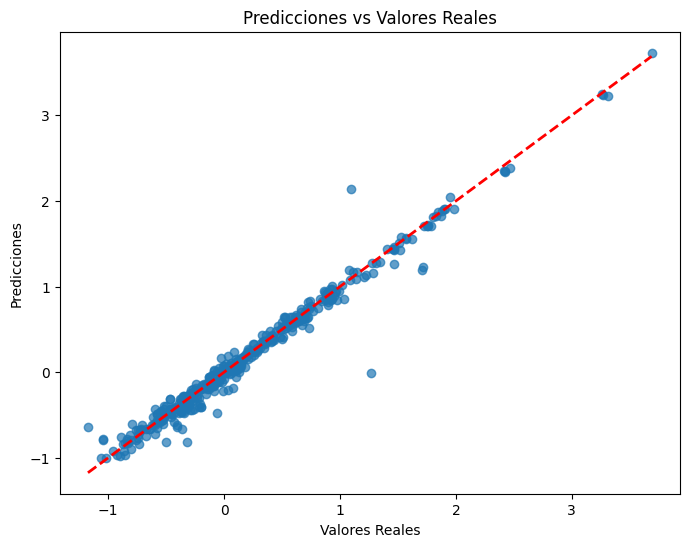

In [59]:
import matplotlib.pyplot as plt

# Predicciones vs Reales
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Línea de identidad
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

**Gráfico de Errores (Residual Plot)**

Este gráfico muestra los errores del modelo (diferencia entre la predicción y el valor real). Deberías ver una distribución de los errores sin patrones sistemáticos si el modelo es bueno.



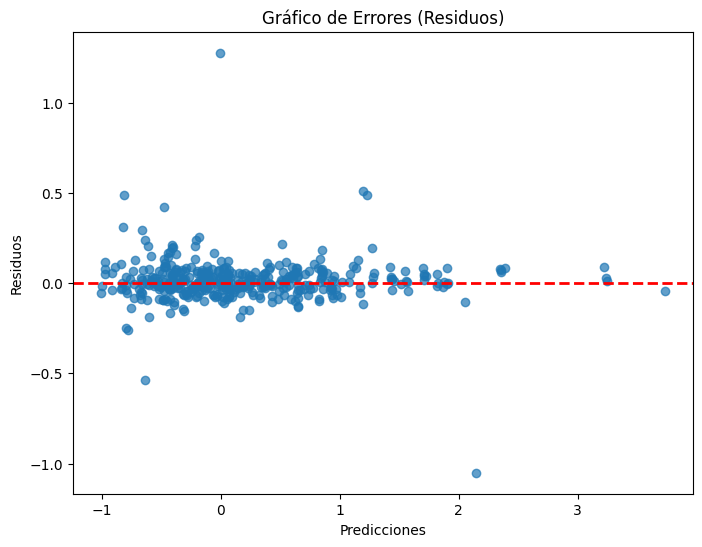

In [60]:
# Cálculo de los errores (residuos)
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title("Gráfico de Errores (Residuos)")
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.show()


**Histograma de Errores**

Un histograma te permitirá ver la distribución de los errores del modelo. Idealmente, debe ser simétrico y centrado alrededor de cero.

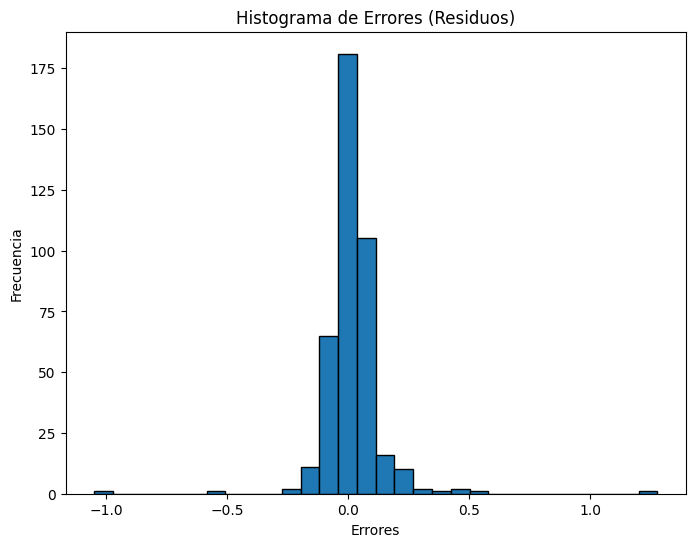

In [61]:
# Histograma de los errores
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Histograma de Errores (Residuos)")
plt.xlabel("Errores")
plt.ylabel("Frecuencia")
plt.show()


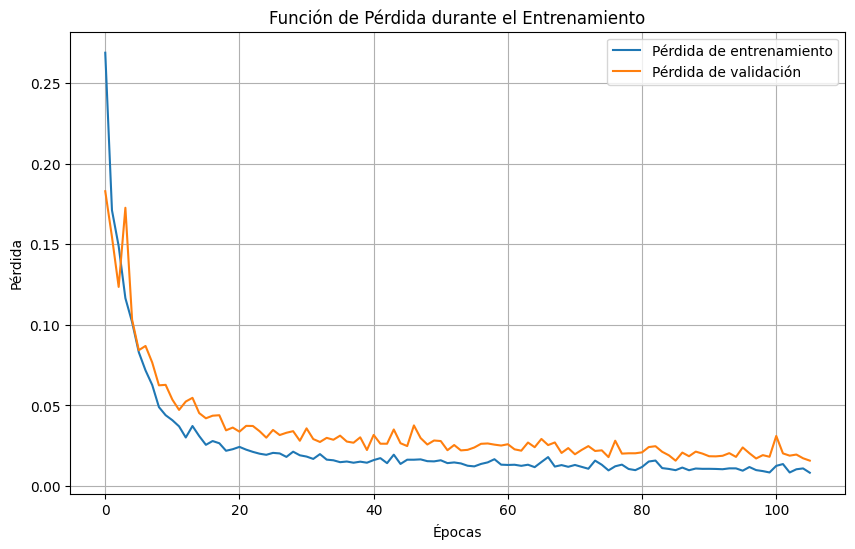

In [62]:
import matplotlib.pyplot as plt

# Graficar la función de pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Función de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

**Métricas de Evaluación en un Solo Gráfico**



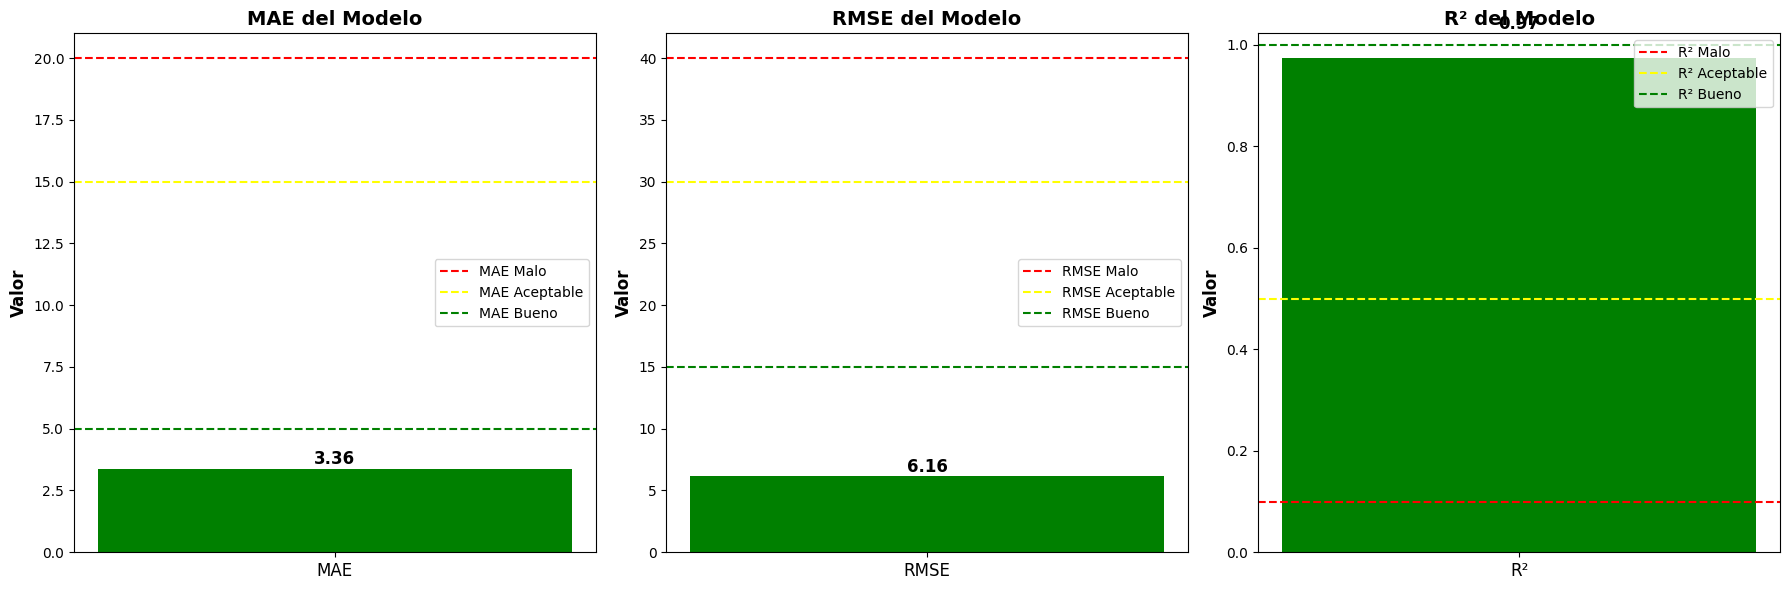

In [66]:
import matplotlib.pyplot as plt

# Definir las métricas
metrics = {'MAE': mae, 'RMSE': rmsr_percentage, 'R²': r2}

# Definir los rangos para cada métrica (Malo, Aceptable, Bueno)
ranges = {
    'MAE': {'min': 20, 'acceptable': 15, 'max': 5},
    'RMSE': {'min': 40, 'acceptable': 30, 'max': 15},
    'R²': {'min': 0.1, 'acceptable': 0.5, 'max': 1}
}

# Crear los gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Para cada métrica, generar un gráfico
for i, (metric, value) in enumerate(metrics.items()):
    ax = axes[i]

    # Determinar el color según el valor de la métrica
    if value <= ranges[metric]['max']:
        color = 'green'  # Bueno
    elif value <= ranges[metric]['acceptable']:
        color = 'yellow'  # Aceptable
    else:
        color = 'red'  # Malo

    # Graficar la barra
    ax.bar(metric, value, color=color)
    ax.text(0, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Añadir las líneas que marcan los límites para cada rango
    ax.axhline(y=ranges[metric]['min'], color='red', linestyle='--', label=f'{metric} Malo')
    ax.axhline(y=ranges[metric]['acceptable'], color='yellow', linestyle='--', label=f'{metric} Aceptable')
    ax.axhline(y=ranges[metric]['max'], color='green', linestyle='--', label=f'{metric} Bueno')

    # Añadir título y etiquetas
    ax.set_title(f"{metric} del Modelo", fontsize=14, fontweight='bold')
    ax.set_ylabel("Valor", fontsize=12, fontweight='bold')
    ax.set_xticks([0])
    ax.set_xticklabels([metric], fontsize=12)

    # Añadir leyenda
    ax.legend(fontsize=10)

# Mejorar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()





## 🗂️ Fase 5: Exportación del Modelo Entrenado

En esta fase, se guarda el modelo entrenado en formatos compatibles para su uso posterior en otros entornos o aplicaciones. El modelo se exporta en formatos `.keras` o `.h5`, los cuales permiten una fácil integración y reutilización en diferentes proyectos o APIs.


In [67]:
# Evaluate the model and calculate accuracy
loss = model.evaluate(X_test, y_test, verbose=0)  # Get the loss value
print("Loss of Model:", loss)  # Print the loss

# To get MAE, you need to calculate it separately
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("MAE of Model:", mae)

# Now you can calculate and print the approximated accuracy
print("Accuracy of Model (approx.):", 1 - mae)

Loss of Model: 0.015739314258098602
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE of Model: 0.06834135204553604
Accuracy of Model (approx.): 0.931658647954464


## 👍 Fase 6: Probar el modelo

### **Paso 1:** Cargar el modelo y los scalers
Si tienes el modelo entrenado guardado, puedes cargarlo con joblib o tensorflow.keras.models.load_model(). Igualmente, necesitarás cargar los scalers para aplicar las mismas transformaciones que usaste durante el entrenamiento.

In [69]:
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.preprocessing import RobustScaler

# Cargar el modelo entrenado (suponiendo que lo hayas guardado con joblib o keras)
model = load_model('best_model.keras')
scaler_y = joblib.load('robust_scaler_y.joblib')
scaler_x = joblib.load('robust_scaler_X.joblib')


### **Paso 2**: Preparar los datos de entrada
Supongamos que tienes un conjunto de parámetros para hacer una predicción. Debes asegurarte de que esos parámetros estén en el mismo formato que usaste para entrenar el modelo. Esto puede incluir la transformación (normalización) de los datos.

In [70]:
# Hacer las predicciones sobre los datos de prueba
y_pred_scaled = model.predict(X_test)

# Invertir la transformación de las predicciones (volver a la escala original)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Invertir la transformación de y_test (volver a la escala original)
y_test_orig = scaler_y.inverse_transform(y_test)

# Calcular el error porcentual
error_percentage = np.abs((y_test_orig - y_pred) / y_test_orig) * 100

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Real Price': y_test_orig.flatten(),
    'Predicted Price': y_pred.flatten(),
    'Error (%)': error_percentage.flatten()
})

# Mostrar las primeras filas de los resultados
print(results.head())


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
   Real Price  Predicted Price  Error (%)
0   4725249.0       4514417.50   4.461807
1   2186004.0       2068919.25   5.356109
2   3115000.0       3149938.50   1.121621
3   5338066.0       5297805.50   0.754215
4   6045158.0       5906815.50   2.288484


Paso 1: Definir los datos manualmente
Lo primero que necesitas es definir las características (features) que pasas manualmente al modelo, tal como lo harías en la API, con un formato similar al siguiente:

Cargar el Data Test con datos reales excluidos desde el principio


In [71]:
# Cargar Data Test
data_test = pd.read_csv("data_test.csv")

data_price_real = data_test['price']
data_test_real = data_test.drop(['price'], axis=1)

# Agregar feature
# Área por habitación (densidad)
data_test_real['area_per_room'] = data_test_real['area'] / (data_test_real['bedrooms'] + data_test_real['bathrooms'])

# Baños por dormitorio
data_test_real['bath_per_bed'] = data_test_real['bathrooms'] / data_test_real['bedrooms']

# Área por piso (stories)
data_test_real['area_per_story'] = data_test_real['area'] / data_test_real['stories']

# Espacio por estacionamiento
data_test_real['area_per_parking'] = data_test_real['area'] / (data_test_real['parking'] + 1)  # +1 para evitar división por cero

data_test_real['total_amenities'] = (
    data_test_real['mainroad'] +
    data_test_real['guestroom'] +
    data_test_real['basement'] +
    data_test_real['hotwaterheating'] +
    data_test_real['airconditioning'] +
    data_test_real['prefarea']
)
data_price_real.head()
data_test_real.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,area_per_room,bath_per_bed,area_per_story,area_per_parking,total_amenities
0,4400,3,1,2,1,0,0,0,0,0,0,0,0,1,1100.000000,0.333333,2200.0,4400.0,1
1,4400,2,1,1,1,0,0,0,0,0,0,0,0,1,1466.666667,0.500000,4400.0,4400.0,1
2,3000,3,1,2,1,0,0,0,0,0,0,0,1,0,750.000000,0.333333,1500.0,3000.0,1
3,5500,4,2,2,1,0,1,0,1,1,1,0,1,0,916.666667,0.500000,2750.0,2750.0,4
4,5850,2,1,1,1,1,1,0,0,2,0,0,1,0,1950.000000,0.500000,5850.0,1950.0,3


In [72]:
# Normalizar:
scaler_test = scaler_x.fit(data_test_real)
data_test_real = scaler_test.transform(data_test_real)
print(data_test_real)

[[ 0.15268709  0.          0.         ... -0.25024534  0.43715847
  -0.5       ]
 [ 0.15268709 -1.          0.         ...  0.61334642  0.43715847
  -0.5       ]
 [-0.4098443   0.          0.         ... -0.52502453 -0.32786885
  -0.5       ]
 ...
 [ 0.19286791 -1.          0.         ...  0.65260059  0.49180328
  -0.5       ]
 [-0.06830738 -1.          0.         ...  0.39744848  0.13661202
  -0.5       ]
 [-0.00803616 -1.          0.         ...  0.45632974  0.21857923
   0.        ]]


In [73]:
# Hacer las predicciones sobre los datos de prueba
prediction = model.predict(data_test_real)

# Invertir la transformación de las predicciones (volver a la escala original)
y_pred_real = scaler_y.inverse_transform(prediction)

# Asegurarse de que tanto 'data_price_real' como 'y_pred_real' sean vectores 1D
data_price_real = data_price_real.values.flatten()  # Si 'data_price_real' es un DataFrame de pandas
y_pred_real = y_pred_real.flatten()  # Aplanar las predicciones

# Calcular el error porcentual
error_percentage = np.abs((data_price_real - y_pred_real) / data_price_real) * 100

# Tabla de comparación de precios
results = pd.DataFrame({
    'Real Price': data_price_real,
    'Predicted Price': y_pred_real,
    'Error (%)': np.round(error_percentage, 1)
})

# Mostrar los resultados
print(results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
    Real Price  Predicted Price  Error (%)
0      2485000       3364379.00       35.4
1      2590000       3460106.00       33.6
2      3920000       3876091.75        1.1
3      8400000       8173772.00        2.7
4      4200000       5687636.50       35.4
5      2852500       3418359.00       19.8
6      5600000       6036430.50        7.8
7      4473000       4789243.00        7.1
8      4095000       5261674.50       28.5
9      2800000       4313287.00       54.0
10     3290000       2631281.50       20.0
11     4200000       3134738.00       25.4
12     4200000       4656312.00       10.9
13     4200000       3179304.50       24.3
14     5250000       3113838.00       40.7
15     5040000       5865750.00       16.4
16     4098500       5623921.50       37.2
17    12215000      10769870.00       11.8
18     4956000       4899068.00        1.1
19     2450000       3999013.00       63.2
20     3115000       2790116.50       10.4
21     4550000  

# 📊 Conclusiones

En este proyecto, se entrenó un modelo de regresión con una red neuronal, utilizando 12 características para predecir el precio de las viviendas. El modelo fue evaluado con métricas como MAE, RMSE y R², y se exportó exitosamente en formatos .keras y .h5 para su futura implementación